<a href="https://colab.research.google.com/github/itchyfeet-patient/Going_Deeper/blob/master/Autonomous_driving_assistance_system/%5BGD_3%5DObject_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6-9. 프로젝트: 자율주행 보조 시스템 만들기 🚗**

## **라이브러리 버전 확인**

In [1]:
import tensorflow as tf
import os, copy
import numpy as np
from PIL import Image, ImageDraw
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


print(tf.__version__)

2.8.2


## **0. 위에서 만든 모델**

### 데이터 파이프 라인
먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 합니다. 이때 사용할 데이터 파이프라인을 구축합니다.

데이터 파이프라인은 총 4단계로 이루어집니다.

1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정  

독립적인 함수를 각각 작성합니다.

In [2]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

슝=3


In [3]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

슝=3


이미지 크기를 바꿀 때는 고려할 점이 있습니다. 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 하거든요. 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들 거예요.

예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다. 여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 이미지로 모델에 입력하겠다는 이야깁니다. 모델에 입력되는 이미지에는 검정 테두리가 있겠군요!

실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride등에 의해 결정돼요. 그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해줍니다.



In [4]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

슝=3


In [5]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

슝=3


In [6]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')


슝=3


### 인코딩
One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됩니다. 그래서 기본적으로 Anchor Box를 생성해줘야 합니다. Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다. 물체 위치를 주관식이 아닌 객관식으로 풀게 하는 겁니다.

예를 들어 100개의 Anchor Box를 생성했다고 가정하면 이미 만들어진 100개의 Anchor Box에 해당하지 않는 위치, 크기, 비율에 물체가 있을 수 없습니다. 100개의 Anchor Box중 가장 근접한 하나가 선택이 되겠죠. 이렇게 선택된 Anchor Box를 기초로 정확한 위치를 찾아냅니다. 추가로 Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아내죠. 게다가 Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있습니다.

또, RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요합니다. FPN의 각 층마다 Anchor Box가 필요하기 때문입니다. RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있습니다.

여기서는 논문과 같은 형태로 Anchor Box를 생성합니다.



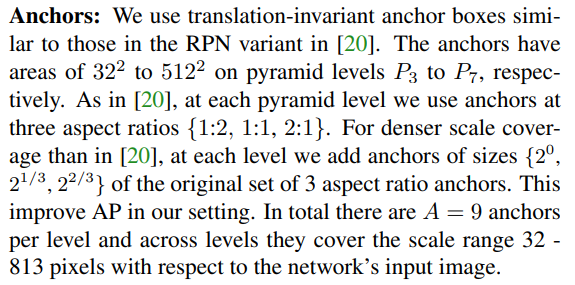

In [7]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

슝=3


이제 Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야 합니다.

데이터 원본의 bbox는 주관식 정답이라고 생각하면 됩니다. 하지만 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습시킬 수 있습니다.

그럼 어떻게 주관식 정답을 객관식 정답으로 바꿀 수 있을까요? 여기에서 IoU를 사용합니다.

IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크해 두는 것이죠. 그러니 IoU를 계산할 수 있는 함수를 만듭니다.

In [8]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

슝=3


이제 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 봅시다. 위에서 작성한 compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다. 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

>이 과정에서 variance가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장합니다.
어디에도 정확한 이유가 등장하지는 않지만 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용합니다.
이와 관련하여 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견이 있습니다.

이 과정은 마치 데이터를 훈련이 가능한 형식으로 encode하는 것 같으니 LabelEncoder라는 이름으로 클래스를 만들었습니다.



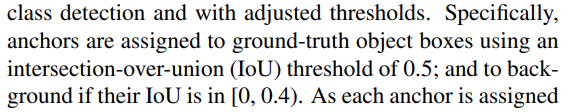

In [9]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

슝=3


이제 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었으니 모델을 만들러 가봅시다.




### 6-6. 모델 작성
### Feature Pyramid
앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다. 완전히 동일한 것은 아니고 약간 수정해서 사용했습니다. 자세한 설명은 아래에 나와있네요.



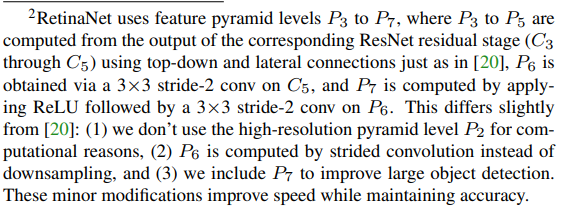

In [10]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 그것을 head라고 부르기도 합니다. Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상합니다. class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있겠죠? class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.

그래서 각각의 head를 만들어 줍니다. head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.

In [11]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


우리가 만들 RetinaNet의 backbone은 ResNet50입니다. FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.



In [12]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


이제 RetinaNet을 완성해 봅시다. Backbone + FPN + classification용 head + box용 head 입니다.

In [13]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


이제 모델을 준비했고, Loss에 대한 준비를 해봅시다.

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. Box Regression에는 Smooth L1 Loss를 사용했네요.

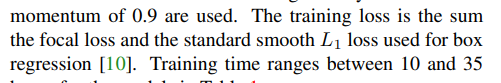content img
[Focal Loss + Smooth L1 Loss]
https://arxiv.org/pdf/1708.02002.pdf
Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!



In [14]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


이제 모든 준비가 끝났습니다. 모델 학습을 할 수 있겠네요!

### 6-7. 모델 학습  
앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습시켜 봅시다.



In [15]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

94781440/94765736 [==============================] - 1s 0us/step
슝=3


모델은 매우 간단하게 만들어 졌네요.

다음으로 Learning Rate입니다. 논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않아요. 그래서 Learning Rate를 적절히 바꿔줍니다.

Optimizer는 동일하게 SGD를 사용합니다.

In [16]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

이제 데이터 전처리를 위한 파이프라인도 만들어 줍니다.

In [17]:
DATA_PATH = '/content/drive/MyDrive/dataset/object_detection/data'

In [18]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

슝=3


이제 학습을 시켜봅시다.

1 epoch당 학습 시간이 상당히 오래 걸리기 때문에 여기서는 학습 시키는 예시 코드만 보여드릴게요. (뒤에선 미리 학습된 모델을 불러와 사용할 예정입니다.😙)

```
model_dir = '/content/drive/MyDrive/dataset/object_detection/data/checkpoints'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)
```

### 6-8. 결과 확인하기
학습된 모델을 불러옵시다.



In [19]:
model_dir = '/content/drive/MyDrive/dataset/object_detection/data/checkpoints'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

슝=3


모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 줍니다. 논문에서는 1000개의 후보를 골라 처리했지만 우리는 100개의 후보만 골라 처리하도록 합시다. 나머지 설정은 논문과 동일하게 해볼게요.



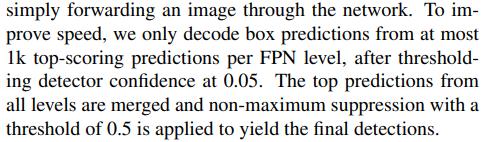

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용했습니다.  
* [tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)  

위 참고자료를 꼭 읽어보세요. 입출력되는 값이 어떤지 알아야 코드가 이해가 됩니다. 특히 출력에 nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections이 각각 무엇인지 알아야 활용할 수 있습니다.

In [20]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

슝=3


이제 추론이 가능한 모델을 조립합니다.

In [21]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

슝=3


모델의 추론 결과를 시각화 할 함수를 만들어 줍니다.

In [22]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

슝=3


이제 추론시에 입력 데이터를 전처리하기 위한 함수를 만들게요.

학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성됩니다. 추론을 위한 전처리가 훨씬 간단하네요.



In [23]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

슝=3


## **1. 자율주행 시스템 만들기**
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

* 입력으로 이미지 경로를 받습니다.
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
* 조건은 다음과 같습니다.
    * 사람이 한 명 이상 있는 경우
    * 차량의 크기(width or height)가 300px이상인 경우

---

이미지를 함봅시다.

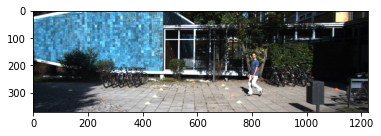

In [24]:
img_path = '/content/drive/MyDrive/dataset/object_detection/data/stop_1.png'

image = Image.open(img_path)
image = np.array(image) # retinanet에 넣기 위해 numpy로 변환
#img = Image.fromarray(image.numpy())
plt.imshow(image)
plt.show()
#draw = ImageDraw.Draw(img)
#draw.rectangle((130, 30, 670, 450), outline=(0,255,0), width=2)

사람이 있으니 멈춰야겠죠

위에서 만든 모델을 적용시켜봅니다.

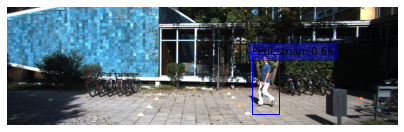

In [25]:
int2str = dataset_info.features["objects"]["type"].int2str

image = tf.cast(image, dtype=tf.float32)
input_image, ratio = prepare_image(image)
detections = inference_model.predict(input_image)
num_detections = detections.valid_detections[0]
class_names = [
    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
]
visualize_detections(
    image,
    detections.nmsed_boxes[0][:num_detections] / ratio,
    class_names,
    detections.nmsed_scores[0][:num_detections],
)

보행자가 검출이 잘됐네요

(1242, 375)


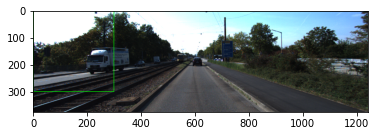

In [26]:
img_path = '/content/drive/MyDrive/dataset/object_detection/data/go_1.png'


image = Image.open(img_path)
print(image.size)
draw = ImageDraw.Draw(image)
draw.rectangle((0, 0, 300, 300), outline=(0,255,0), width=2)
image = np.array(image)
plt.imshow(image)
plt.show()

사람이 없고 차량의 크기(width or height)가 300px 미만이라서 달려도 됩니다.  
차량의 크기를 앞차와의 거리로 대신했네요.  
이러면 다른차선의 차량이 크게 보일때는 어떡하나요? 멈춰야하나요?

참고로 좌상단의 네모네모가 300px(30*10) 입니다. 너무작은뎅 

**아 가로 300 세로 300 인것 같습니다! (수정)**  
width or height 가 300이니까 둘 중 하나만이라도 300 미만이면 되겠습니다.  
수정된 바운딩박스는 좌상단에서 보이고 있습니다.

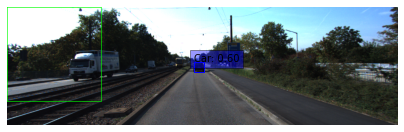

In [27]:
int2str = dataset_info.features["objects"]["type"].int2str

image = tf.cast(image, dtype=tf.float32)
input_image, ratio = prepare_image(image)
detections = inference_model.predict(input_image)
# detections = tf.image.combined_non_max_suppression 의 결과물
# 'nmsed_boxes', 'nmsed_scores', 'nmsed_classes', 'valid_detections'

num_detections = detections.valid_detections[0]
# valid_detections : 배치 항목당 유효한 detections를 나타내는 int32 텐서
# detection 1개 됐으니까 1일것

class_names = [
    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
]

visualize_detections(
    image,
    detections.nmsed_boxes[0][:num_detections] / ratio,
    class_names,
    detections.nmsed_scores[0][:num_detections],
)

차도 검출이 잘됐고요

---

이제 자율주행 보조시스템을 만들어 보겠습니다.  
정지조건에 맞는 경우 'Stop' 아닌 경우 'Go'를 반환합니다.  
 
**⛔ 정지조건**  
* 사람이 한 명 이상 있는 경우
* 차량의 크기 (width or height) 가 300px이상인 경우

일단 반환되어 나오는 NMS의 출력을 알아야 BBox의 정보를 알 수 있겠죠?


바로 위에서 확인해봤던 이미지에서 NMS의 출력을 눈으로 보겠습니다.

**nmsed_boxes** (float32)  
NMS box들이 들어있습니다.  
위 이미지에서는 검출된 객체가 한개라 한개뿐인 것을 확인할 수 있습니다.

In [28]:
print(detections.nmsed_boxes)

[[[635.62115 180.75772 672.2729  214.82587]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]
  [  0.        0.        0.     

**nmsed_scores** (float32)  
각 Box들의 score를 가집니다. 여기서는 60점이네요?

In [29]:
print(detections.nmsed_scores)

[[0.5992277 0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]]


**nmsed_classes** (float32)  
각 box에 대한 class를 가집니다.  
'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc'(기타) or 'DontCare' 이 순서대로 class 번호가 부여되어 있습니다.  
위 이미지에는 car를 검출해서 가장 첫번째 원소가 '0'입니다. pedestrian을 검출했을 때는 '3'이 부여되는 것을 확인할 수 있었습니다.

In [30]:
print(detections.nmsed_classes)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]


**valid_detections**  
배치 항목당 유효한 detections 수를 나타내는 int32 텐서입니다.  
여기서는 1개만 검출되었으니 1을 가집니다.

In [31]:
print(detections.valid_detections)

[1]


먼저 사람이 한명 이상 있을 때 보행자가 있는 첫번째 이미지를 참고해서 만들어 보겠습니다.  

* 클래스 중 'Pedestrian', 'Person_sitting', 'Cyclist' 을 사람이라고 간주했습니다. 각각의 클래스 번호는 3, 4, 5입니다.
* 마찬가지로 'Car', 'Van', 'Truck'을 차량이라고 간주했습니다. 클래스 번호는 0, 1, 2 입니다.

In [34]:
from collections import Counter

detections_class = detections.nmsed_classes[0][:num_detections]
person = np.array([3, 4, 5])
person_num = 0

if person in detections_class:
    # 사람에 해당하는 원소 개수 세기
    for i in range(3, 6):
        person_num += Counter(detections_class)[i]
    if person_num >= 1:
        print('사람있어요 🙋‍♀️')
else:
    print('지나가세요 🚙🚗🚕💨')
# 사실 여기서 else도 추가로 작성해줘야함 불완전한 코드임을 감안해주세요

지나가세요 🚙🚗🚕💨


사람이 있으면 사람있어요 / 없으면 지나가세요~ 가 잘 나옵니다. (얼추 코딩한 내용이고 미흡한 부분은 후에 수정할 예정)

---

다음은 차량의 크기가 300px 이상인 경우  
box의 좌표가 나와있는 `detections.nmsed_boxes` 배열을 이용해보겠습니다.

In [35]:
detections.nmsed_boxes.shape

(1, 100, 4)

In [82]:
detections.nmsed_boxes[0][:num_detections][0]

array([635.62115, 180.75772, 672.2729 , 214.82587], dtype=float32)

첫번째 배치의[0] , 검출된 전체 box까지[:num_detections], 첫번째 원소[0] 라는 뜻이당.

In [65]:
detections.nmsed_boxes[0][:2][:]

array([[635.62115, 180.75772, 672.2729 , 214.82587],
       [  0.     ,   0.     ,   0.     ,   0.     ]], dtype=float32)

In [98]:
detections.nmsed_boxes[0][:2][1]

array([0., 0., 0., 0.], dtype=float32)

지금은 box가 하나만 검출되어서 `:num_detections` 로 하면 오류가 생기지만 여러 개 검출됐다면 `:num_detections`으로 검출된 좌표값을 모두 출력하고, 마지막 []로 몇번째 box를 선택할 지 정할 수 있다.

```
[635.62115 180.75772 672.2729  214.82587]
```

아무튼 이 값들을 이용해서 차량의 크기를 구해보고자 합니다.

In [37]:
x1, y1, x2, y2 = detections.nmsed_boxes[0][:num_detections][0]
w = x2-x1
h = y2-y1
print(w, h)

36.651733 34.068146


이렇게 구한 width와 height로 크기를 구해봅니다.

In [38]:
if w <= 300 or h <= 300:
    print('Go')
else:
    print('Stop')

Go


근데이제 class가 차여야 하니까

In [39]:
print(detections.nmsed_classes[0][:num_detections])

[0.]


Car, Van, Truck 각각 클래스 0,1,2 값이어야 한다는 조건도 추가해줍니다.

In [40]:
detections_class = np.array([0., 1., 6.])

In [41]:
x1, y1, x2, y2 = detections.nmsed_boxes[0][:num_detections][0]
w = x2-x1
h = y2-y1

detections_class = detections.nmsed_classes[0][:num_detections]
car = np.array([0, 1, 2])
if car in detections_class:
    if w <= 300 or h <= 300:
        print('Go')
    else:
        print('Stop')

Go


정리해서 순서도를 그려봤습니다.

![image drawio (1)](https://user-images.githubusercontent.com/108614874/194758673-bba55e0c-90b2-4532-b1b0-637521c00203.png)

틀린 결과를 시각화하기 위해 `visualize`함수를 만들어줍니다.

In [42]:
def visualize(img_path):
    image = Image.open(img_path)
    image = np.array(image)
    int2str = dataset_info.features["objects"]["type"].int2str

    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    # detections = tf.image.combined_non_max_suppression 의 결과물
    # 'nmsed_boxes', 'nmsed_scores', 'nmsed_classes', 'valid_detections'

    num_detections = detections.valid_detections[0]
    # valid_detections : 배치 항목당 유효한 detections를 나타내는 int32 텐서
    # detection 1개 됐으니까 1일것

    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]

    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )


여차저차 만들어본 `self_drive_assist` 함수입니다.

In [45]:
def self_drive_assist_wrong(img_path, size_limit=300):
    detections, num_detections = retinanet_modify(img_path)
    x1, y1, x2, y2 = detections.nmsed_boxes[0][:num_detections][0]
    w = x2-x1
    h = y2-y1
    person_num = 0
    person = np.array([3, 4, 5])
    car = np.array([0, 1, 2])
    detections_class = detections.nmsed_classes[0][:num_detections]

    if detections_class in person:
        for i in range(3, 6):
            person_num += Counter(detections_class)[i]
            if person_num >= 1:
                print('멈춰멈춰 ⛔🙋‍♀️')
                return '멈춰멈춰 ⛔🙋‍♀️'

    elif detections_class in car:
        if w >= 300 or h >= 300 :
            print('멈춰멈춰 ⛔🙋‍♀️')
            return '멈춰멈춰 ⛔🙋‍♀️'
        else:
            print('지나가세요 🚙🚗🚕💨')
            return '지나가세요 🚙🚗🚕💨'
    else:
        print('지나가세요 🚙🚗🚕💨')
        return '지나가세요 🚙🚗🚕💨'

## **2. 자율주행 시스템 평가하기**
아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

### **☝ 첫 번째 시도**

/content/drive/MyDrive/dataset/object_detection/data/stop_1.png
멈춰멈춰 ⛔🙋‍♀️
/content/drive/MyDrive/dataset/object_detection/data/stop_2.png
멈춰멈춰 ⛔🙋‍♀️
/content/drive/MyDrive/dataset/object_detection/data/stop_3.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


지나가세요 🚙🚗🚕💨


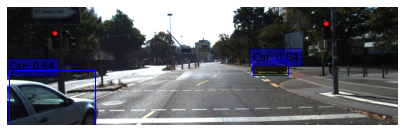

/content/drive/MyDrive/dataset/object_detection/data/stop_4.png
지나가세요 🚙🚗🚕💨


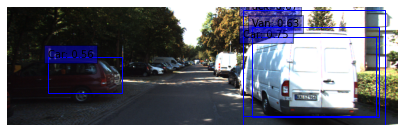

/content/drive/MyDrive/dataset/object_detection/data/stop_5.png
멈춰멈춰 ⛔🙋‍♀️
/content/drive/MyDrive/dataset/object_detection/data/go_1.png
지나가세요 🚙🚗🚕💨
/content/drive/MyDrive/dataset/object_detection/data/go_2.png
지나가세요 🚙🚗🚕💨
/content/drive/MyDrive/dataset/object_detection/data/go_3.png
지나가세요 🚙🚗🚕💨
/content/drive/MyDrive/dataset/object_detection/data/go_4.png
지나가세요 🚙🚗🚕💨
/content/drive/MyDrive/dataset/object_detection/data/go_5.png
지나가세요 🚙🚗🚕💨
80점입니다.


In [99]:
def test_system(func):
    work_dir = '/content/drive/MyDrive/dataset/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", '멈춰멈춰 ⛔🙋‍♀️'),
        ("stop_2.png", '멈춰멈춰 ⛔🙋‍♀️'),
        ("stop_3.png", '멈춰멈춰 ⛔🙋‍♀️'),
        ("stop_4.png", '멈춰멈춰 ⛔🙋‍♀️'),
        ("stop_5.png", '멈춰멈춰 ⛔🙋‍♀️'),
        ("go_1.png", '지나가세요 🚙🚗🚕💨'),
        ("go_2.png", '지나가세요 🚙🚗🚕💨'),
        ("go_3.png", '지나가세요 🚙🚗🚕💨'),
        ("go_4.png", '지나가세요 🚙🚗🚕💨'),
        ("go_5.png", '지나가세요 🚙🚗🚕💨'),
    ]
    
    for image_file, answer in test_set:
        img_path = work_dir + '/' + image_file
        print(img_path)
        pred = func(img_path)
        
        if pred == answer:
            score += 10
        else:
            visualize(img_path)
    print(f"{score}점입니다.")

test_system(self_drive_assist_wrong)



여러개 디텍션됐을 때 틀리는 것을 보니 거기서 문제가 있나 봅니다. w, h 계산하는 부분을 수정해줘야 할 듯 싶습니다.

* 수정사항
    * 여러개 디텍션 됐을때 w, h 계산하는 부분
    * 코드다듬기
    * 90점만들기
    * 순서도 그림그려서 첨부

---

**처음 작성한 코드**  
* 코드를 분석해 보니 car class 인식을 전혀 못했다. car, person class 중 무엇도 아닌 클래스로 인식을 했다. label이라는 변수를 생성해서 class를 담아주는 방법으로 바꿨다.  

```

    if detections_class in person:
        for i in range(3, 6):
            person_num += Counter(detections_class)[i]
            if person_num >= 1:
                return '멈춰멈춰 ⛔🙋‍♀️'

    elif detections_class in car:
        if w >= 300 or h >= 300 or :
            return '멈춰멈춰 ⛔🙋‍♀️'
        else:
            return '지나가세요 🚙🚗🚕💨'
    else:
        return '지나가세요 🚙🚗🚕💨'

```

**다음으로 작성한 코드**
- 여러개 검출했을 때에 문제가 있어서 range(num_detection)을 사용했다. 처음 코드에서는 첫번째로 검출된 값만 사용했는데 이제는 검출된 bbox를 모두 조건에 검사할 수 있는 코드가 되었다.  
- 코드에 if문을 너무 많이 쓰니 오래걸리고 가독성도 떨어져서 if문을 다 합쳐줬다. 

```
def self_drive_assist(img_path, size_limit=300):
    detections, num_detections = retinanet_modify(img_path)
    x1, y1, x2, y2 = detections.nmsed_boxes[0][:num_detections][0]
    w = x2-x1
    h = y2-y1
    person_num = 0
    person = np.array([3, 4, 5])
    car = np.array([0, 1, 2])
    detections_class = detections.nmsed_classes[0][:num_detections]

    for j in range(num_detections):
        label = detections.nmsed_classes[0][j]
        print(w,h)
        if label in person:
            for i in range(3, 6):
                person_num += Counter(detections_class)[i]
                if person_num >= 1:
                    print('멈춰멈춰 ⛔🙋‍♀️')
                    return '멈춰멈춰 ⛔🙋‍♀️'
        elif (w >= 300 or h >= 300) and (label in car) :
            print('멈춰멈춰 ⛔🙋‍♀️')
            return '멈춰멈춰 ⛔🙋‍♀️'
            
        else:
            print('지나가세요 🚙🚗🚕💨')
            return '지나가세요 🚙🚗🚕💨'
```

### **✌ 두 번째 시도**

수정된 `self_drive_assist`입니당

In [79]:
from collections import Counter
def retinanet_modify(img_path):
    image = Image.open(img_path)
    image = np.array(image)
    image = tf.cast(image, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    return detections, num_detections

def self_drive_assist(img_path, size_limit=300):
    detections, num_detections = retinanet_modify(img_path)
    detections_class = detections.nmsed_classes[0][:num_detections]

    person_num = 0
    person = np.array([3, 4, 5])
    car = np.array([0, 1, 2])

    for j in range(num_detections):
        label = detections.nmsed_classes[0][j]
        x1, y1, x2, y2 = detections.nmsed_boxes[0][:num_detections][j]
        w = x2-x1
        h = y2-y1
        print(w,h)
        print('클래스는? : ', label)
        
        for i in range(3,6):
            person_num += Counter(detections_class)[i]
        print('몇명? : ', person_num)
        if ((label in person) and person_num >= 1) or ((w >= 300 or h >= 300) and (label in car)):
            print('멈춰멈춰 ⛔🙋‍♀️')
            return '멈춰멈춰 ⛔🙋‍♀️'
            break
        else: 
            print('지나가세요 🚙🚗🚕💨')
            return '지나가세요 🚙🚗🚕💨'      


/content/drive/MyDrive/dataset/object_detection/data/stop_1.png
91.476074 203.58743
클래스는? :  3.0
몇명? :  1
멈춰멈춰 ⛔🙋‍♀️


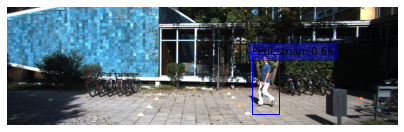

/content/drive/MyDrive/dataset/object_detection/data/stop_2.png
92.88733 218.03387
클래스는? :  3.0
몇명? :  1
멈춰멈춰 ⛔🙋‍♀️


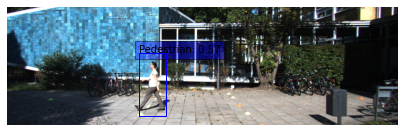

/content/drive/MyDrive/dataset/object_detection/data/stop_3.png
292.83154 190.11385
클래스는? :  0.0
몇명? :  0
지나가세요 🚙🚗🚕💨


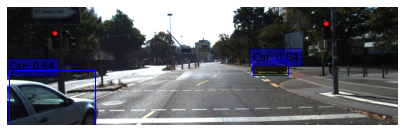

/content/drive/MyDrive/dataset/object_detection/data/stop_4.png
453.85004 267.78455
클래스는? :  0.0
몇명? :  0
멈춰멈춰 ⛔🙋‍♀️


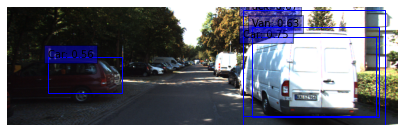

/content/drive/MyDrive/dataset/object_detection/data/stop_5.png
424.25024 250.60815
클래스는? :  0.0
몇명? :  0
멈춰멈춰 ⛔🙋‍♀️


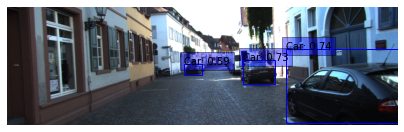

/content/drive/MyDrive/dataset/object_detection/data/go_1.png
36.651733 34.068146
클래스는? :  0.0
몇명? :  0
지나가세요 🚙🚗🚕💨


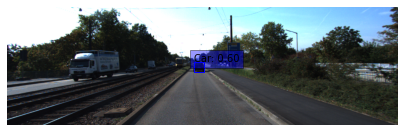

/content/drive/MyDrive/dataset/object_detection/data/go_2.png
62.993042 40.8219
클래스는? :  0.0
몇명? :  0
지나가세요 🚙🚗🚕💨


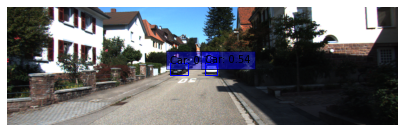

/content/drive/MyDrive/dataset/object_detection/data/go_3.png
33.772095 25.750092
클래스는? :  0.0
몇명? :  0
지나가세요 🚙🚗🚕💨


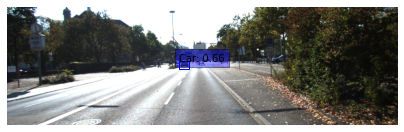

/content/drive/MyDrive/dataset/object_detection/data/go_4.png
92.53821 64.353455
클래스는? :  0.0
몇명? :  0
지나가세요 🚙🚗🚕💨


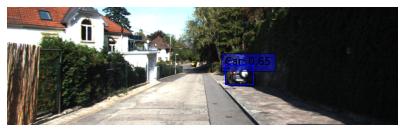

/content/drive/MyDrive/dataset/object_detection/data/go_5.png
183.47601 79.68088
클래스는? :  0.0
몇명? :  0
지나가세요 🚙🚗🚕💨


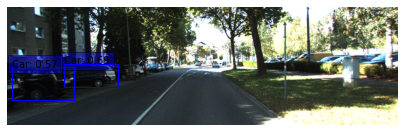

90점입니다.


In [80]:
test_system(self_drive_assist)



수정된 코드로 돌려보니 90점이 나왔다. 한개 틀린건데  

![image](https://user-images.githubusercontent.com/108614874/194698074-29c2cb15-b072-4b27-81d6-93b7380f254d.png)   

여기 위에 `292.83154 190.11385` 이게 width, height를 출력해 본 수치다.  
좌측하단의 bounding box를 292.83154, 190.11385로 출력한것!  
조건이 애초에 300px 이상이어야 정지하라! 여서 Stop일 수가 없었다. 나는 label이 틀렸다고 생각한다. (내가 맞다 이거야)

---

### **🍔 루브릭**
| 평가문항 | 상세기준 | 학습결과 |
|:---:|:---:|:---:|
| 1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다. | KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다. | O |
| 2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다. | 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다. | O |
| 3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다. | 테스트 수행결과 90% 이상의 정확도를 보였다. | O : 90점 달성|

### **🙋 회고**

* Detection 힘둘ㄷ다. anchor box 만드는 것 부터해서 형태 맞춰주는거랑 신경써줄게 너무 많다. 흑훅 
* retinanet 되게 빨랐다.

* 오랜만에 코딩을 해서 재밌었다. 주어진 조건이 단순해 보여 금방 할 수 있으리라 생각했는데 쉽지 않았다. nms의 출력값을 이해하고, 조건을 순서도로 그려서 차근차근 진행했다. 깔끔하게 코드를 짜는게 쉽지 않았다!
* 형태 맞춰주고 타입 맞춰주는 게 힘듬..
* 머리속에서 생각한 방법을 구현해내기 쉽지 않다.
* img_path, image_path... detection, detections 등 나도 모르게 비슷한 변수명을 사용해서 혼동이 왔고 실수를 하게 됐다. 직관적인 함수명을 사용하는게 쉽지 않다.


* 여러가지 경우의 수를 고려해서 코딩해야 했기때문에 수정을 열심히 했다. 허점투성이였다..! 
* 그럼에도 불구하고 원하는 결과가 나오긴 했다. 그러면 test 이미지들에는 적용이 되겠지만 다른 이미지들은 틀릴 수 있기 때문에 수정해줬다.

* 오늘 내 코드 요약  

![image](https://user-images.githubusercontent.com/108614874/194759126-a462f1aa-a0d5-4b80-bc16-ef35afc9d6be.png)

### **🔖참고문헌**

[PIL 이미지를 Numpy 배열로 변환](https://www.delftstack.com/ko/howto/numpy/pil-image-to-numpy-array/)  
[tf.image.combined_non_max_suppression](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)  
[Counter로 배열 원소세기](https://dev-note-97.tistory.com/17)
